# Comparing our algortihm against the primal dual algortihm by Jing et al. (2022) - Difference of energy at the end of the algortihm

In this notebook, we compare our proximal algorithm and the algorithm by Jing et al. (2022) by comparing the energy value at the end of the iteration. In particular, we plot the difference $(\textrm{our energy}) - (\textrm{Jing et al. energy})$. If this is positive, then ours is larger, and if this is negative, then theirs is larger.

Jing, Y., Chen, J., Li, L., & Lu, J. (2022). A deep learning framework for geodesics under spherical Wasserstein-Fisher-Rao metric and its application for weighted sample generation. arXiv. https://arxiv.org/abs/2208.12145

In [20]:
# Importing the required libraries
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import sys
sys.path.append('../../..')
from proximal.grids import speed_and_growth
from proximal.dynamicUOT import computeGeodesic
import ipywidgets as widgets
from ipywidgets import interact
import matplotlib.animation as animation
import matlab.engine
import io

# Set up

Here, we will create the densities we will use for the transport. We consider the spatial domain $[0,1]$ and the densities are chosen as follows:

$\rho_0(x) =  a N(x|b, 1/10) + (1-a)N(x, c, 1/10)$


$\rho_0(x) =  d N(x|e, 1/10) + (1-d)N(x, f, 1/10)$

where $N(x|\mu, \sigma^2)$ denotes the pdf of normal distribtuion of mean $\mu$ and variance $\sigma^2$ and $a,b,c,d,e, f$ are taken from the uniform distribution on $[0,1]$.


In [21]:
def generate_distribution(Nx):
    """ Generate initial and the terminal distribution according to the formula above.

    Args:
        Nx: Number of points in the grid.
    
    Returns:
        mu0: The initial distribution.
        mu1: The terminal distribution.
    """

    a, b, c, d, e, f = np.random.uniform(0, 1, 6)
    x = np.linspace(0, 1, Nx)
    dx = 1/Nx
    mu_0 = a * sp.stats.norm.pdf(x, b, 1/10) + (1-a)* sp.stats.norm.pdf(x, c, 1/10)
    mu_1 = d * sp.stats.norm.pdf(x, e, 1/10) + (1-d)* sp.stats.norm.pdf(x, f, 1/10)
    mu_0 /= np.sum(mu_0) * dx
    mu_1 /= np.sum(mu_1) * dx
    return mu_0, mu_1

# Calculation

✨ Starting MATLAB Engine... 🛠️
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal transport with source...
Progress: 99%
Done.
Computing a geodesic for optimal 

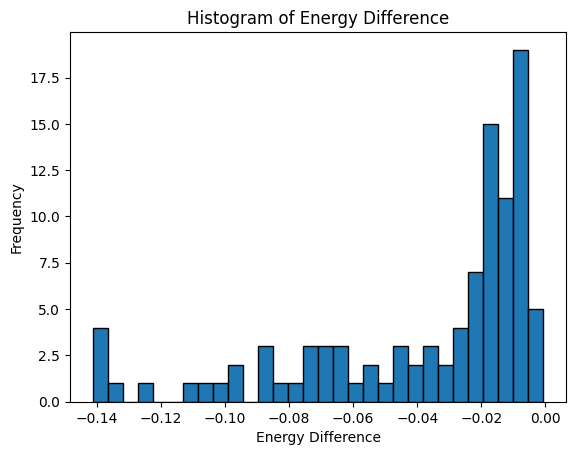

In [22]:
# Parameters
Nx = 60 # The size of the spatial grid
Nt = 15 # The size of the temporal grid

# Parameters for our algorithm
delta = 1.0
# We use the default alpha and gamma for the DR algortihm

# Parameters for Jing et al. (2022)
alpha = 1.0  # Originally 5
mu = 0.0007 # Originally 0.007
tao = 0.0007 # Originally 0.007
N_itr = 10000  # Originally 1000000

X = [0, 1]
T = [0, 1]
dx = (X[1] - X[0]) / Nx
dt = 1 / Nt
x_space = np.linspace(X[0], X[1], Nx)
t_space = np.linspace(T[0], T[1], Nt)

rho_0, rho_1 = generate_distribution(256)

# starting MATLAB engine
output_buffer = io.StringIO()
print('✨ Starting MATLAB Engine... 🛠️')
eng = matlab.engine.start_matlab()
eng.cd(r'..\..\..')
eng.cd(r'.\proximal\code_from_jing_et_al_2022', nargout=0)

energy_diff = []

nan_count = 0
for _ in range(100):
    rho_0, rho_1 = generate_distribution(Nx)
    # our algorithm
    ll = (1.0, 1.0)
    x_ours, lists = computeGeodesic(rho_0, rho_1, Nt, ll, p= 2.0, q=2.0, delta=delta, niter=N_itr)
    # Jing et al. (2022)
    eng.workspace['Nx'] = float(Nx)
    eng.workspace['Nt'] = float(Nt)
    eng.workspace['alpha'] = float(alpha)
    eng.workspace['mu'] = mu
    eng.workspace['tao'] = tao
    eng.workspace['N_itr'] = N_itr
    eng.workspace['X'] = X
    eng.workspace['T'] = T
    eng.workspace['dx'] = dx
    eng.workspace['dt'] = dt
    eng.workspace['x_space'] = matlab.double(x_space.tolist())
    eng.workspace['t_space'] = matlab.double(t_space.tolist())
    eng.workspace['rho_0'] = matlab.double(rho_0.tolist())
    eng.workspace['rho_1'] = matlab.double(rho_1.tolist())
    eng.WFR_main(nargout=0, stdout=output_buffer)
    D = eng.workspace['D']
    if D == D:
        energy_diff.append(x_ours.V.energy(delta=1.0, p=2.0, q=2.0) - D*dx*dt)
    else:
        print('Jing et al. (2022) failed to converge.')
        nan_count += 1

# Calculate mean and variance
mean_energy_diff = np.mean(energy_diff)
variance_energy_diff = np.var(energy_diff)

# Print mean and variance
print(f"Mean of energy difference: {mean_energy_diff}")
print(f"Variance of energy difference: {variance_energy_diff}")
print(f"Number of NaNs: {nan_count}")

# Plot histogram
plt.hist(energy_diff, bins=30, edgecolor='black')
plt.title('Histogram of Energy Difference')
plt.xlabel('Energy Difference')
plt.ylabel('Frequency')
plt.show()